In [1]:
import numpy as np
from scipy.linalg import eig, svd
import deeptime as dt
from deeptime.numeric import is_sorted, spd_inv_sqrt, schatten_norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyemma.msm import MSM

ModuleNotFoundError: No module named 'deeptime'

In [ ]:
T = np.

In [302]:
def vamp(mod,  dim: int = 2, epsilon: float = 1e-15, ignore_tt=False) -> float: 
    
#     # Get the covariance koopman model
#     est = dt.markov.msm.MaximumLikelihoodMSM(reversible=reversible, lagtime=lag)
#     est.fit(dtrajs)
#     mod = est.fetch_model()
    
    cmat = mod.count_model.count_matrix
    tmat = mod.transition_matrix
    
    # Empirical covariances
    cov0t = cmat
    cov00 = np.diag(cov0t.sum(axis=1))
    if ignore_tt: 
        covtt = cov00
    else:
        covtt = np.diag(cov0t.sum(axis=0))
    
    # Symmetrized tmat
    
    # reweight operator to empirical distribution
    C0t_re = cov00 @ tmat
    # symmetrized operator and SVD
    tmat_sym = np.linalg.multi_dot([spd_inv_sqrt(cov00, epsilon=epsilon, method='QR'), C0t_re,
                                 spd_inv_sqrt(covtt, epsilon=epsilon, method='QR')])
    
        
#     print('norm(K.T - K) = ', schatten_norm(tmat_sym.T - tmat_sym, 2) ** 2)
    
    # SVD
    U, singular_values, Vt = svd(tmat_sym, compute_uv=True)
    U = spd_inv_sqrt(cov00, epsilon=epsilon) @ U
    Vt = Vt @ spd_inv_sqrt(covtt, epsilon=epsilon)
    V = Vt.T
    
    
    # Sort by singular values
    sort_ix = np.argsort(singular_values)[::-1][:dim]  # indices to sort in descending order
    U = U[:, sort_ix]
    V = V[:, sort_ix]
    singular_values = singular_values[sort_ix]
    
    
    
    
    A = np.atleast_2d(spd_inv_sqrt(U.T.dot(cov00).dot(U), epsilon=epsilon))
    B = np.atleast_2d(U.T.dot(cov0t).dot(V))
    C = np.atleast_2d(spd_inv_sqrt(V.T.dot(covtt).dot(V), epsilon=epsilon))
    ABC = np.linalg.multi_dot([A, B, C])
    vamp1 = schatten_norm(ABC, 1) ** 1
    vamp2 = schatten_norm(ABC, 2) ** 2
    
#     with np.printoptions(precision=10):
#         print('A: ')
#         print(np.round(A, 10))
#         print('B: ')
#         print(np.round(B, 10))
#         print('C: ')
#         print(np.round(C, 10))
#         print('Lambdas     =', mod.eigenvalues(2))
#         print('Singulars   =', singular_values[:2])
#         print('Lambdas^2   =', mod.eigenvalues(2)**2)
#         print('Singulars^2 =', singular_values[:2]**2)
        
#         print('Sum lambdas =   ', np.round(mod.eigenvalues(2).sum(), 4))
#         print('VAMP1 =         ', np.round(vamp1, 4))
#         print('Sum lambdas^2 = ', np.round((mod.eigenvalues(2)**2).sum(), 4))
#         print('VAMP2 =         ', np.round(vamp2, 4))              
#         print(f't_2 =            {np.round(mod.timescales(1)[0], 0)}')
#     print('-'*80)
    return vamp2, (mod.eigenvalues(2)**2).sum(), mod.timescales(1)[0]


def non_rev_mod(C0t, delta=0, mask=None):
    C0t_emp = C0t.astype(int)
    
    add = int((delta/100)*(np.min(C0t_emp)))*mask
    sub = np.diag(add.sum(axis=1))
    
    
    C0t_emp += add
    C0t_emp -= sub

    assert C0t.sum() == C0t_emp.sum()
    
    cmod = dt.markov.TransitionCountModel(count_matrix=C0t_emp)
    est = dt.markov.msm.MaximumLikelihoodMSM(lagtime=1, reversible=True)
    est.fit_from_counts(cmod)
    msm = est.fetch_model()
    return msm, schatten_norm(C0t_emp.T - C0t_emp, 2) ** 2, np.sum(add)


In [303]:
C0t = np.array([[95, 5, 1], [5, 95, 2], [3, 5, 90]])
# C0t = np.array([[80, 5], [5, 80]])
C0t = 10*(0.5*(C0t + C0t.T)).astype(int)
C0t

array([[950,  50,  20],
       [ 50, 950,  30],
       [ 20,  30, 900]])

In [308]:
scores = []
evs = []
ts = []
errs = []
deltas = []
iteration = []
masks = []
totals = []
np.random.seed(52)
for i in range(20):
    n_states = C0t.shape[0]
    mask = (np.random.random(C0t.shape) > 0.5) & (np.diag(np.repeat([1], n_states))!=1)
    masks.append(mask)
    
    for delta in np.arange(0, 50):
        msm, err, tot = non_rev_mod(C0t, delta=delta, mask=mask)
        score, ev, t = vamp(msm)
        scores.append(score)
        evs.append(ev)
        ts.append(t)
        errs.append(err)
        deltas.append(delta)
        iteration.append(i)
        totals.append(tot)
df = pd.DataFrame(dict(vamp2 = scores, evs = evs, timescales=ts, deltas=deltas, err=errs, 
                       iteration=iteration, count_diff=totals))

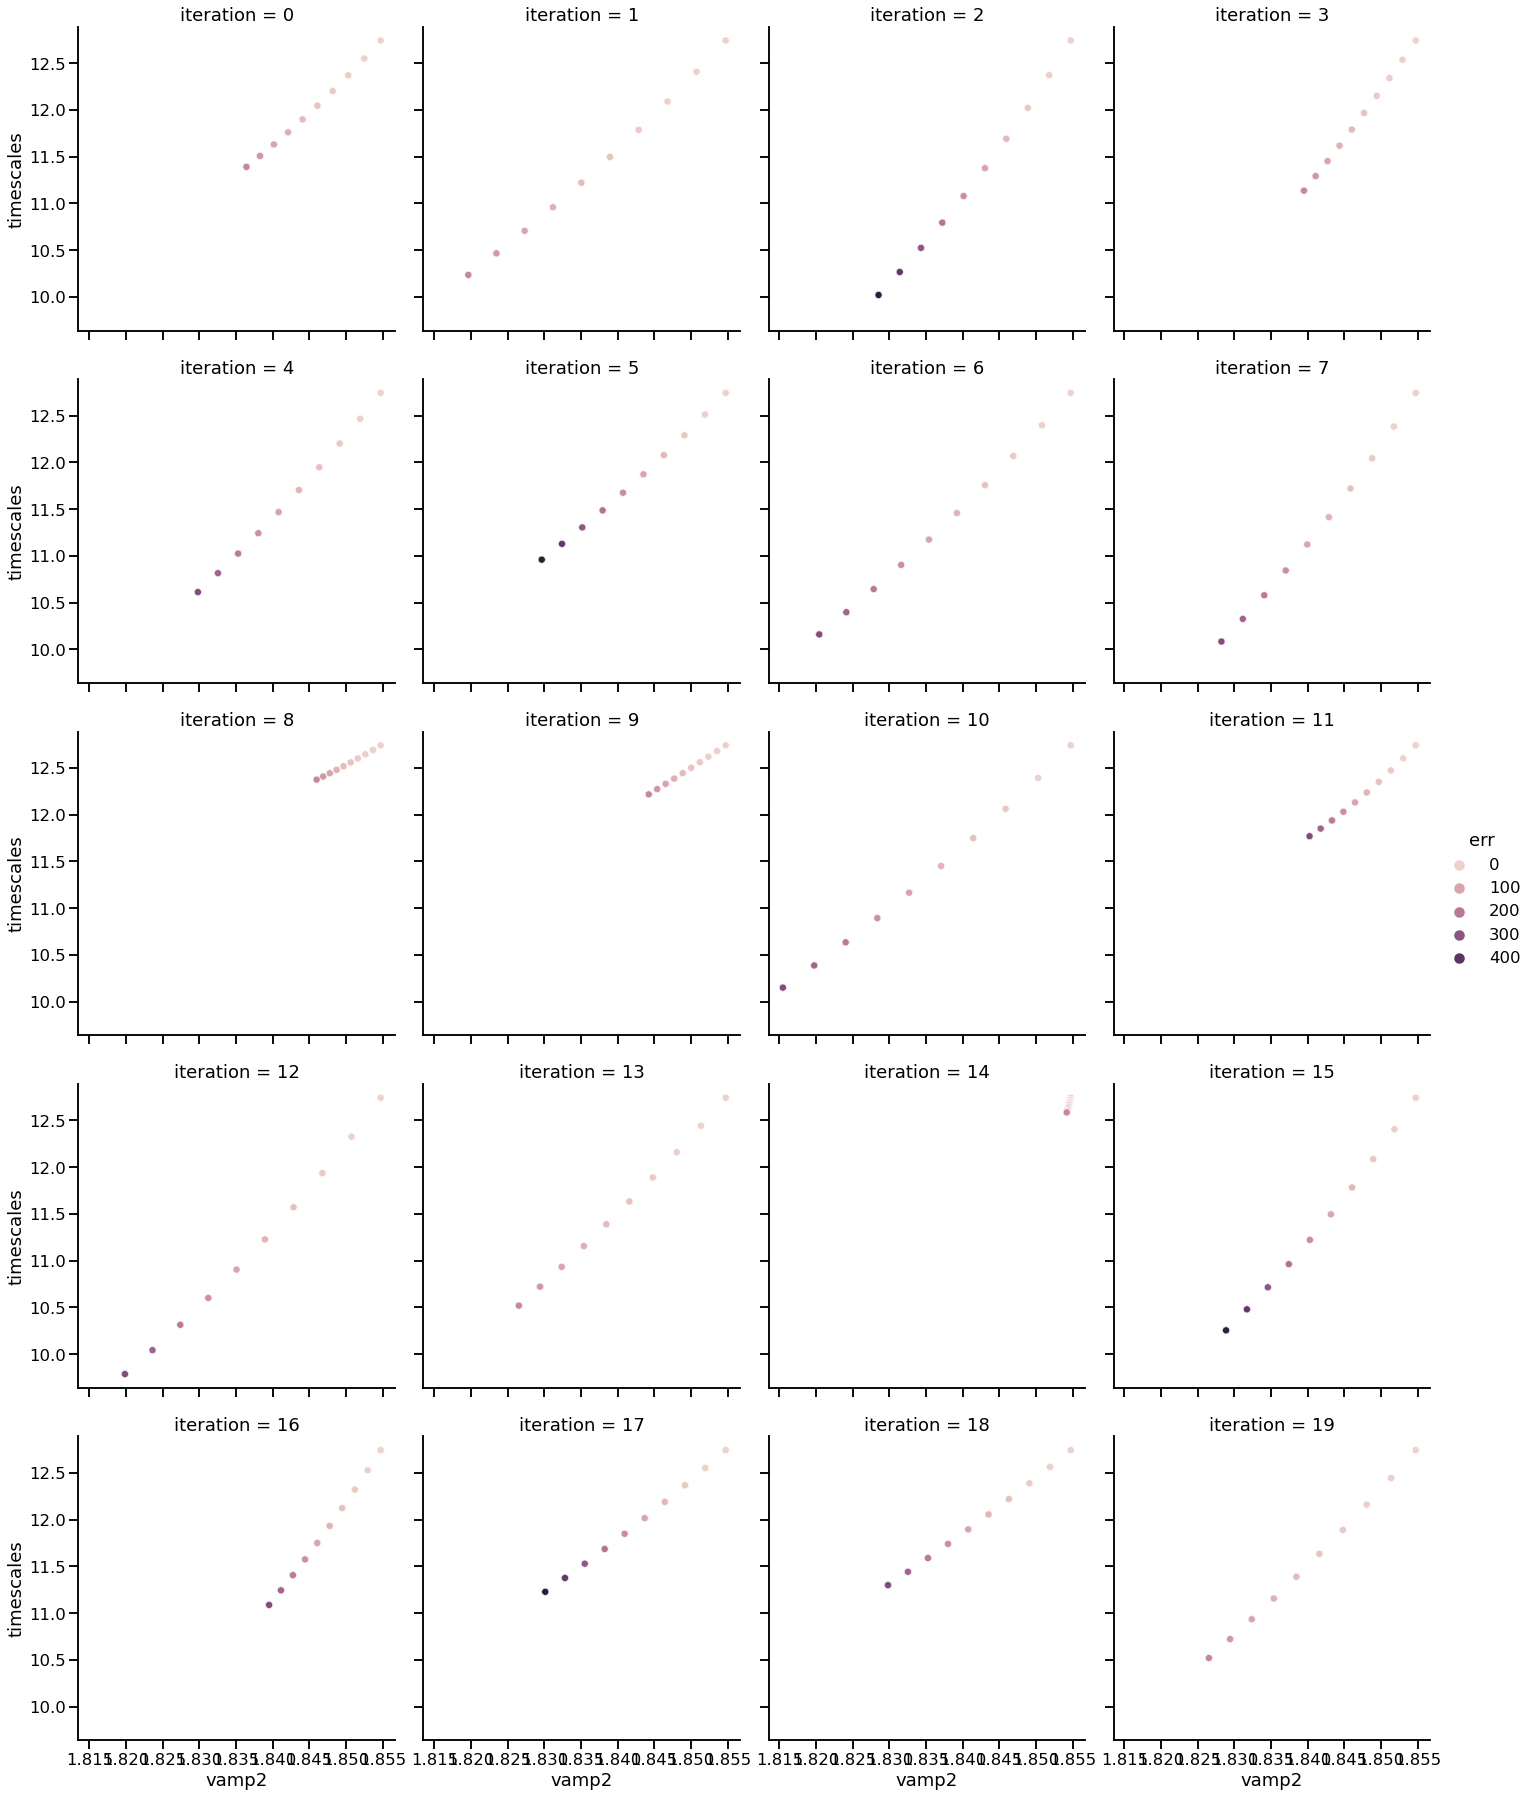

In [309]:
with sns.plotting_context('talk'):
    g = sns.relplot(data=df, x='vamp2', y='timescales', s=50, hue='err', col='iteration', col_wrap=4)
    plt.savefig('ts_vs_vamp_by_iteration.png', dpi=500)
    # g.set(xlim=(1.675, 1.750))

In [ ]:
with sns.plotting_context('talk'):
    g = sns.relplot(data=df, x='vamp2', y='timescales', hue='err', s=50)
    plt.savefig('ts_vs_vamp_by.png', dpi=500)
    # g.set(xlim=(1.675, 1.750))

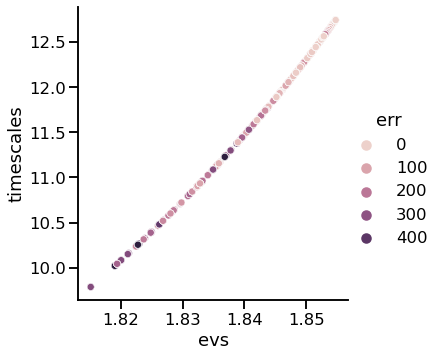

In [314]:
with sns.plotting_context('talk'):
    g = sns.relplot(data=df, x='evs', y='timescales', hue='err', s=50)
    plt.savefig('ts_vs_evs.png', dpi=500)
    # g.set(xlim=(1.675, 1.750))

In [316]:
df.query('deltas==49').sort_values(by=['timescales'], ascending=False)

,vamp2,evs,timescales,deltas,err,iteration,count_diff
749,1.854189,1.853068,12.585280,49,162.0,14,9
449,1.845997,1.850769,12.375085,49,162.0,8,9
499,1.844238,1.848995,12.217303,49,162.0,9,27
599,1.840249,1.843729,11.769941,49,324.0,11,18
49,1.836422,1.838972,11.390964,49,162.0,0,27
949,1.829808,1.837761,11.298009,49,324.0,18,36
899,1.830118,1.836823,11.226921,49,486.0,17,27
199,1.839482,1.835606,11.136006,49,162.0,3,27
849,1.839519,1.834939,11.086677,49,324.0,16,18
299,1.829640,1.833187,10.959046,49,486.0,5,27


In [322]:
100*45*2/C0t.sum()

3.0